In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import tensorflow as tf
from keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, r2_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
# import lightgbm as lgb
import joblib
from scipy import stats
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow.keras.losses import MeanSquaredError
import tensorflow.keras.backend as K
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectKBest, chi2

In [32]:
df_test = pd.read_csv("./datasets/test.csv",  encoding='iso-8859-1', sep=';')
df_train = pd.read_csv("./datasets/train.csv",  encoding='iso-8859-1', sep=';')
df_sub = pd.read_csv("./datasets/Submission.csv",  encoding='iso-8859-1', sep=';')

In [33]:
df_train.head()

,ID,time,temperature_2m (EEC),relative_humidity_2m (%),dew_point_2m (EEC),apparent_temperature (EEC),precipitation (mm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),...,soil_moisture_100_to_255cm (m?/m?),shortwave_radiation (W/m?),direct_radiation (W/m?),diffuse_radiation (W/m?),direct_normal_irradiance (W/m?),global_tilted_irradiance (W/m?),terrestrial_radiation (W/m?),is_day (),sunshine_duration (s),electricity_shutdown
0,1,2022-01-01T00:00,NaN,91.0,"20,7","25,7","0,1","1011,4","987,2",52.0,...,"0,323",0,0,0,0,0,0,0,0,0.0
1,2,2022-01-01T01:00,"22,2",89.0,"20,3","25,5",0,"1010,9","986,7",NaN,...,"0,323",0,0,0,0,0,0,0,0,0.0
2,3,2022-01-01T02:00,NaN,87.0,"20,2","25,4",0,1010,"985,8",42.0,...,"0,323",0,0,0,0,0,0,0,0,0.0
3,4,2022-01-01T03:00,"22,5",86.0,"20,1","25,1",0,1010,"985,8",43.0,...,"0,323",0,0,0,0,0,0,0,0,0.0
4,5,2022-01-01T04:00,"22,7",84.0,"19,9","25,6",0,"1009,8","985,7",NaN,...,"0,323",0,0,0,0,0,NaN,0,0,0.0


In [34]:
df_train.dtypes

ID                                         int64
time                                      object
temperature_2m (EEC)                    object
relative_humidity_2m (%)                 float64
dew_point_2m (EEC)                      object
apparent_temperature (EEC)              object
precipitation (mm)                        object
pressure_msl (hPa)                        object
surface_pressure (hPa)                    object
cloud_cover (%)                          float64
cloud_cover_low (%)                      float64
cloud_cover_mid (%)                      float64
cloud_cover_high (%)                       int64
vapour_pressure_deficit (kPa)             object
wind_speed_10m (km/h)                     object
wind_speed_100m (km/h)                    object
wind_direction_10m (EE)                float64
wind_direction_100m (EE)               float64
wind_gusts_10m (km/h)                     object
soil_temperature_0_to_7cm (EEC)         object
soil_temperature_7_t

In [35]:
df_train.isna().sum()

ID                                          0
time                                        0
temperature_2m (EEC)                   8021
relative_humidity_2m (%)                 1759
dew_point_2m (EEC)                        0
apparent_temperature (EEC)                0
precipitation (mm)                       3542
pressure_msl (hPa)                          0
surface_pressure (hPa)                   1814
cloud_cover (%)                          4351
cloud_cover_low (%)                      3541
cloud_cover_mid (%)                      2624
cloud_cover_high (%)                        0
vapour_pressure_deficit (kPa)            1784
wind_speed_10m (km/h)                    3492
wind_speed_100m (km/h)                      0
wind_direction_10m (EE)                1699
wind_direction_100m (EE)               1796
wind_gusts_10m (km/h)                    2604
soil_temperature_0_to_7cm (EEC)           0
soil_temperature_7_to_28cm (EEC)          0
soil_temperature_28_to_100cm (EE

In [36]:
temp_precip = df_train["precipitation (mm)"]
temp_electricity = df_train["electricity_shutdown"]

df_train.drop(columns=["electricity_shutdown", "precipitation (mm)"], inplace = True)

In [37]:
temp_precip.isna().sum()

3542

In [38]:
temp_electricity.value_counts()

electricity_shutdown
0.0    13858
1.0      131
Name: count, dtype: int64

In [39]:
print(len(df_train))
print(len(df_test))

17520
4368


In [40]:
df_full = pd.concat([df_train, df_test], axis = 0)
len(df_full)

21888

In [41]:
df_full.isna().sum()

ID                                          0
time                                        0
temperature_2m (EEC)                   9988
relative_humidity_2m (%)                 2206
dew_point_2m (EEC)                        0
apparent_temperature (EEC)                0
pressure_msl (hPa)                          0
surface_pressure (hPa)                   2264
cloud_cover (%)                          5461
cloud_cover_low (%)                      4449
cloud_cover_mid (%)                      3250
cloud_cover_high (%)                        0
vapour_pressure_deficit (kPa)            2205
wind_speed_10m (km/h)                    4384
wind_speed_100m (km/h)                      0
wind_direction_10m (EE)                2138
wind_direction_100m (EE)               2246
wind_gusts_10m (km/h)                    3273
soil_temperature_0_to_7cm (EEC)           0
soil_temperature_7_to_28cm (EEC)          0
soil_temperature_28_to_100cm (EEC)        0
soil_temperature_100_to_255cm (E

In [42]:
df_full.dtypes

ID                                         int64
time                                      object
temperature_2m (EEC)                    object
relative_humidity_2m (%)                 float64
dew_point_2m (EEC)                      object
apparent_temperature (EEC)              object
pressure_msl (hPa)                        object
surface_pressure (hPa)                    object
cloud_cover (%)                          float64
cloud_cover_low (%)                      float64
cloud_cover_mid (%)                      float64
cloud_cover_high (%)                       int64
vapour_pressure_deficit (kPa)             object
wind_speed_10m (km/h)                     object
wind_speed_100m (km/h)                    object
wind_direction_10m (EE)                float64
wind_direction_100m (EE)               float64
wind_gusts_10m (km/h)                     object
soil_temperature_0_to_7cm (EEC)         object
soil_temperature_7_to_28cm (EEC)        object
soil_temperature_28_

In [ ]:
columns_to_convert = ['temperature_2m (EEC)', 'surface_pressure (hPa)', 'vapour_pressure_deficit (kPa)', 'wind_speed_10m (km/h)', 'wind_gusts_10m (km/h)', 'soil_moisture_28_to_100cm (m?/m?)', 'terrestrial_radiation (W/m?)', 'sunshine_duration (s)']
df_full[columns_to_convert] = df_full[columns_to_convert].apply(lambda x: x.str.replace(',', '.'))
df_full[columns_to_convert] = df_full[columns_to_convert].apply(pd.to_numeric)

In [ ]:
df_full.dtypes

In [ ]:
df_full['time'] = pd.to_datetime(df_full['time'], format='%m/%d/%Y %H:%M:%S')

df_full['time'] = df_full['time'].dt.strftime('%d-%m-%Y %H:%M:%S')

In [ ]:
df_full.isna().sum()

In [ ]:
df_full.head()

In [ ]:
df_full = df_full.interpolate(method='linear', limit_direction='both')

In [44]:
df_full.isna().sum()

ID                                          0
time                                        0
temperature_2m (EEC)                   9988
relative_humidity_2m (%)                 2206
dew_point_2m (EEC)                        0
apparent_temperature (EEC)                0
pressure_msl (hPa)                          0
surface_pressure (hPa)                   2264
cloud_cover (%)                          5461
cloud_cover_low (%)                      4449
cloud_cover_mid (%)                      3250
cloud_cover_high (%)                        0
vapour_pressure_deficit (kPa)            2205
wind_speed_10m (km/h)                    4384
wind_speed_100m (km/h)                      0
wind_direction_10m (EE)                2138
wind_direction_100m (EE)               2246
wind_gusts_10m (km/h)                    3273
soil_temperature_0_to_7cm (EEC)           0
soil_temperature_7_to_28cm (EEC)          0
soil_temperature_28_to_100cm (EEC)        0
soil_temperature_100_to_255cm (E

In [45]:
df_train.tail()

,ID,time,temperature_2m (EEC),relative_humidity_2m (%),dew_point_2m (EEC),apparent_temperature (EEC),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),...,soil_moisture_28_to_100cm (m?/m?),soil_moisture_100_to_255cm (m?/m?),shortwave_radiation (W/m?),direct_radiation (W/m?),diffuse_radiation (W/m?),direct_normal_irradiance (W/m?),global_tilted_irradiance (W/m?),terrestrial_radiation (W/m?),is_day (),sunshine_duration (s)
17515,17516,2023-12-31T19:00,"24,7",93.0,"23,5",30,"1011,5","987,5",59.0,24.0,...,"0,184","0,206",0,0,0,0,0,0,0,0
17516,17517,2023-12-31T20:00,NaN,94.0,"23,8","30,5","1011,9","987,9",NaN,NaN,...,"0,184","0,206",0,0,0,0,0,0,0,0
17517,17518,2023-12-31T21:00,NaN,NaN,"23,4","29,4","1012,6","988,5",78.0,33.0,...,NaN,"0,206",0,0,0,0,0,0,0,0
17518,17519,2023-12-31T22:00,NaN,93.0,"22,9",29,1012,"987,9",44.0,12.0,...,"0,184","0,206",0,0,0,0,0,0,0,NaN
17519,17520,2023-12-31T23:00,"23,6",95.0,"22,8","28,5","1011,8","987,7",53.0,22.0,...,"0,184","0,206",0,0,0,0,0,0,0,0


In [46]:
df_test.head()

,ID,time,temperature_2m (EEC),relative_humidity_2m (%),dew_point_2m (EEC),apparent_temperature (EEC),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),...,soil_moisture_28_to_100cm (m?/m?),soil_moisture_100_to_255cm (m?/m?),shortwave_radiation (W/m?),direct_radiation (W/m?),diffuse_radiation (W/m?),direct_normal_irradiance (W/m?),global_tilted_irradiance (W/m?),terrestrial_radiation (W/m?),is_day (),sunshine_duration (s)
0,17521,2024-01-01T00:00,"23,7",94.0,"22,8","28,6","1011,6","987,5",NaN,56.0,...,"0,184","0,206",0,0,0,0,0,0,0,0
1,17522,2024-01-01T01:00,NaN,95.0,"22,6","28,4","1010,8",NaN,49.0,20.0,...,"0,185","0,206",0,0,0,0,0,NaN,0,0
2,17523,2024-01-01T02:00,NaN,95.0,"22,5","28,1","1010,3","986,2",NaN,37.0,...,"0,185","0,206",0,0,0,0,0,0,0,0
3,17524,2024-01-01T03:00,NaN,88.0,"22,3","29,4","1010,3",NaN,97.0,NaN,...,"0,185","0,206",0,0,0,0,0,0,0,0
4,17525,2024-01-01T04:00,NaN,90.0,"22,4","29,1","1010,3",NaN,100.0,NaN,...,"0,185","0,206",0,0,0,0,0,0,0,0


In [47]:
df_full.drop(columns="ID", inplace = True)

In [48]:
df_train = df_full.head(17520)
df_test = df_full.tail(4368)

In [49]:
df_train.loc[:, "precipitation (mm)"] = temp_precip
df_train.loc[:, "electricity_shutdown"] = temp_electricity

/var/folders/9d/fp3wp_nx6xqbblmg0zr1yk700000gn/T/ipykernel_12572/13243335.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, "precipitation (mm)"] = temp_precip
/var/folders/9d/fp3wp_nx6xqbblmg0zr1yk700000gn/T/ipykernel_12572/13243335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, "electricity_shutdown"] = temp_electricity


In [50]:
df_train.isna().sum()

time                                        0
temperature_2m (EEC)                   8021
relative_humidity_2m (%)                 1759
dew_point_2m (EEC)                        0
apparent_temperature (EEC)                0
pressure_msl (hPa)                          0
surface_pressure (hPa)                   1814
cloud_cover (%)                          4351
cloud_cover_low (%)                      3541
cloud_cover_mid (%)                      2624
cloud_cover_high (%)                        0
vapour_pressure_deficit (kPa)            1784
wind_speed_10m (km/h)                    3492
wind_speed_100m (km/h)                      0
wind_direction_10m (EE)                1699
wind_direction_100m (EE)               1796
wind_gusts_10m (km/h)                    2604
soil_temperature_0_to_7cm (EEC)           0
soil_temperature_7_to_28cm (EEC)          0
soil_temperature_28_to_100cm (EEC)        0
soil_temperature_100_to_255cm (EEC)       0
soil_moisture_0_to_7cm (m?/m?)    

In [51]:
df_train.set_index('time', inplace=True)
df_test.set_index('time', inplace=True)

/opt/anaconda3/envs/Lomba/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


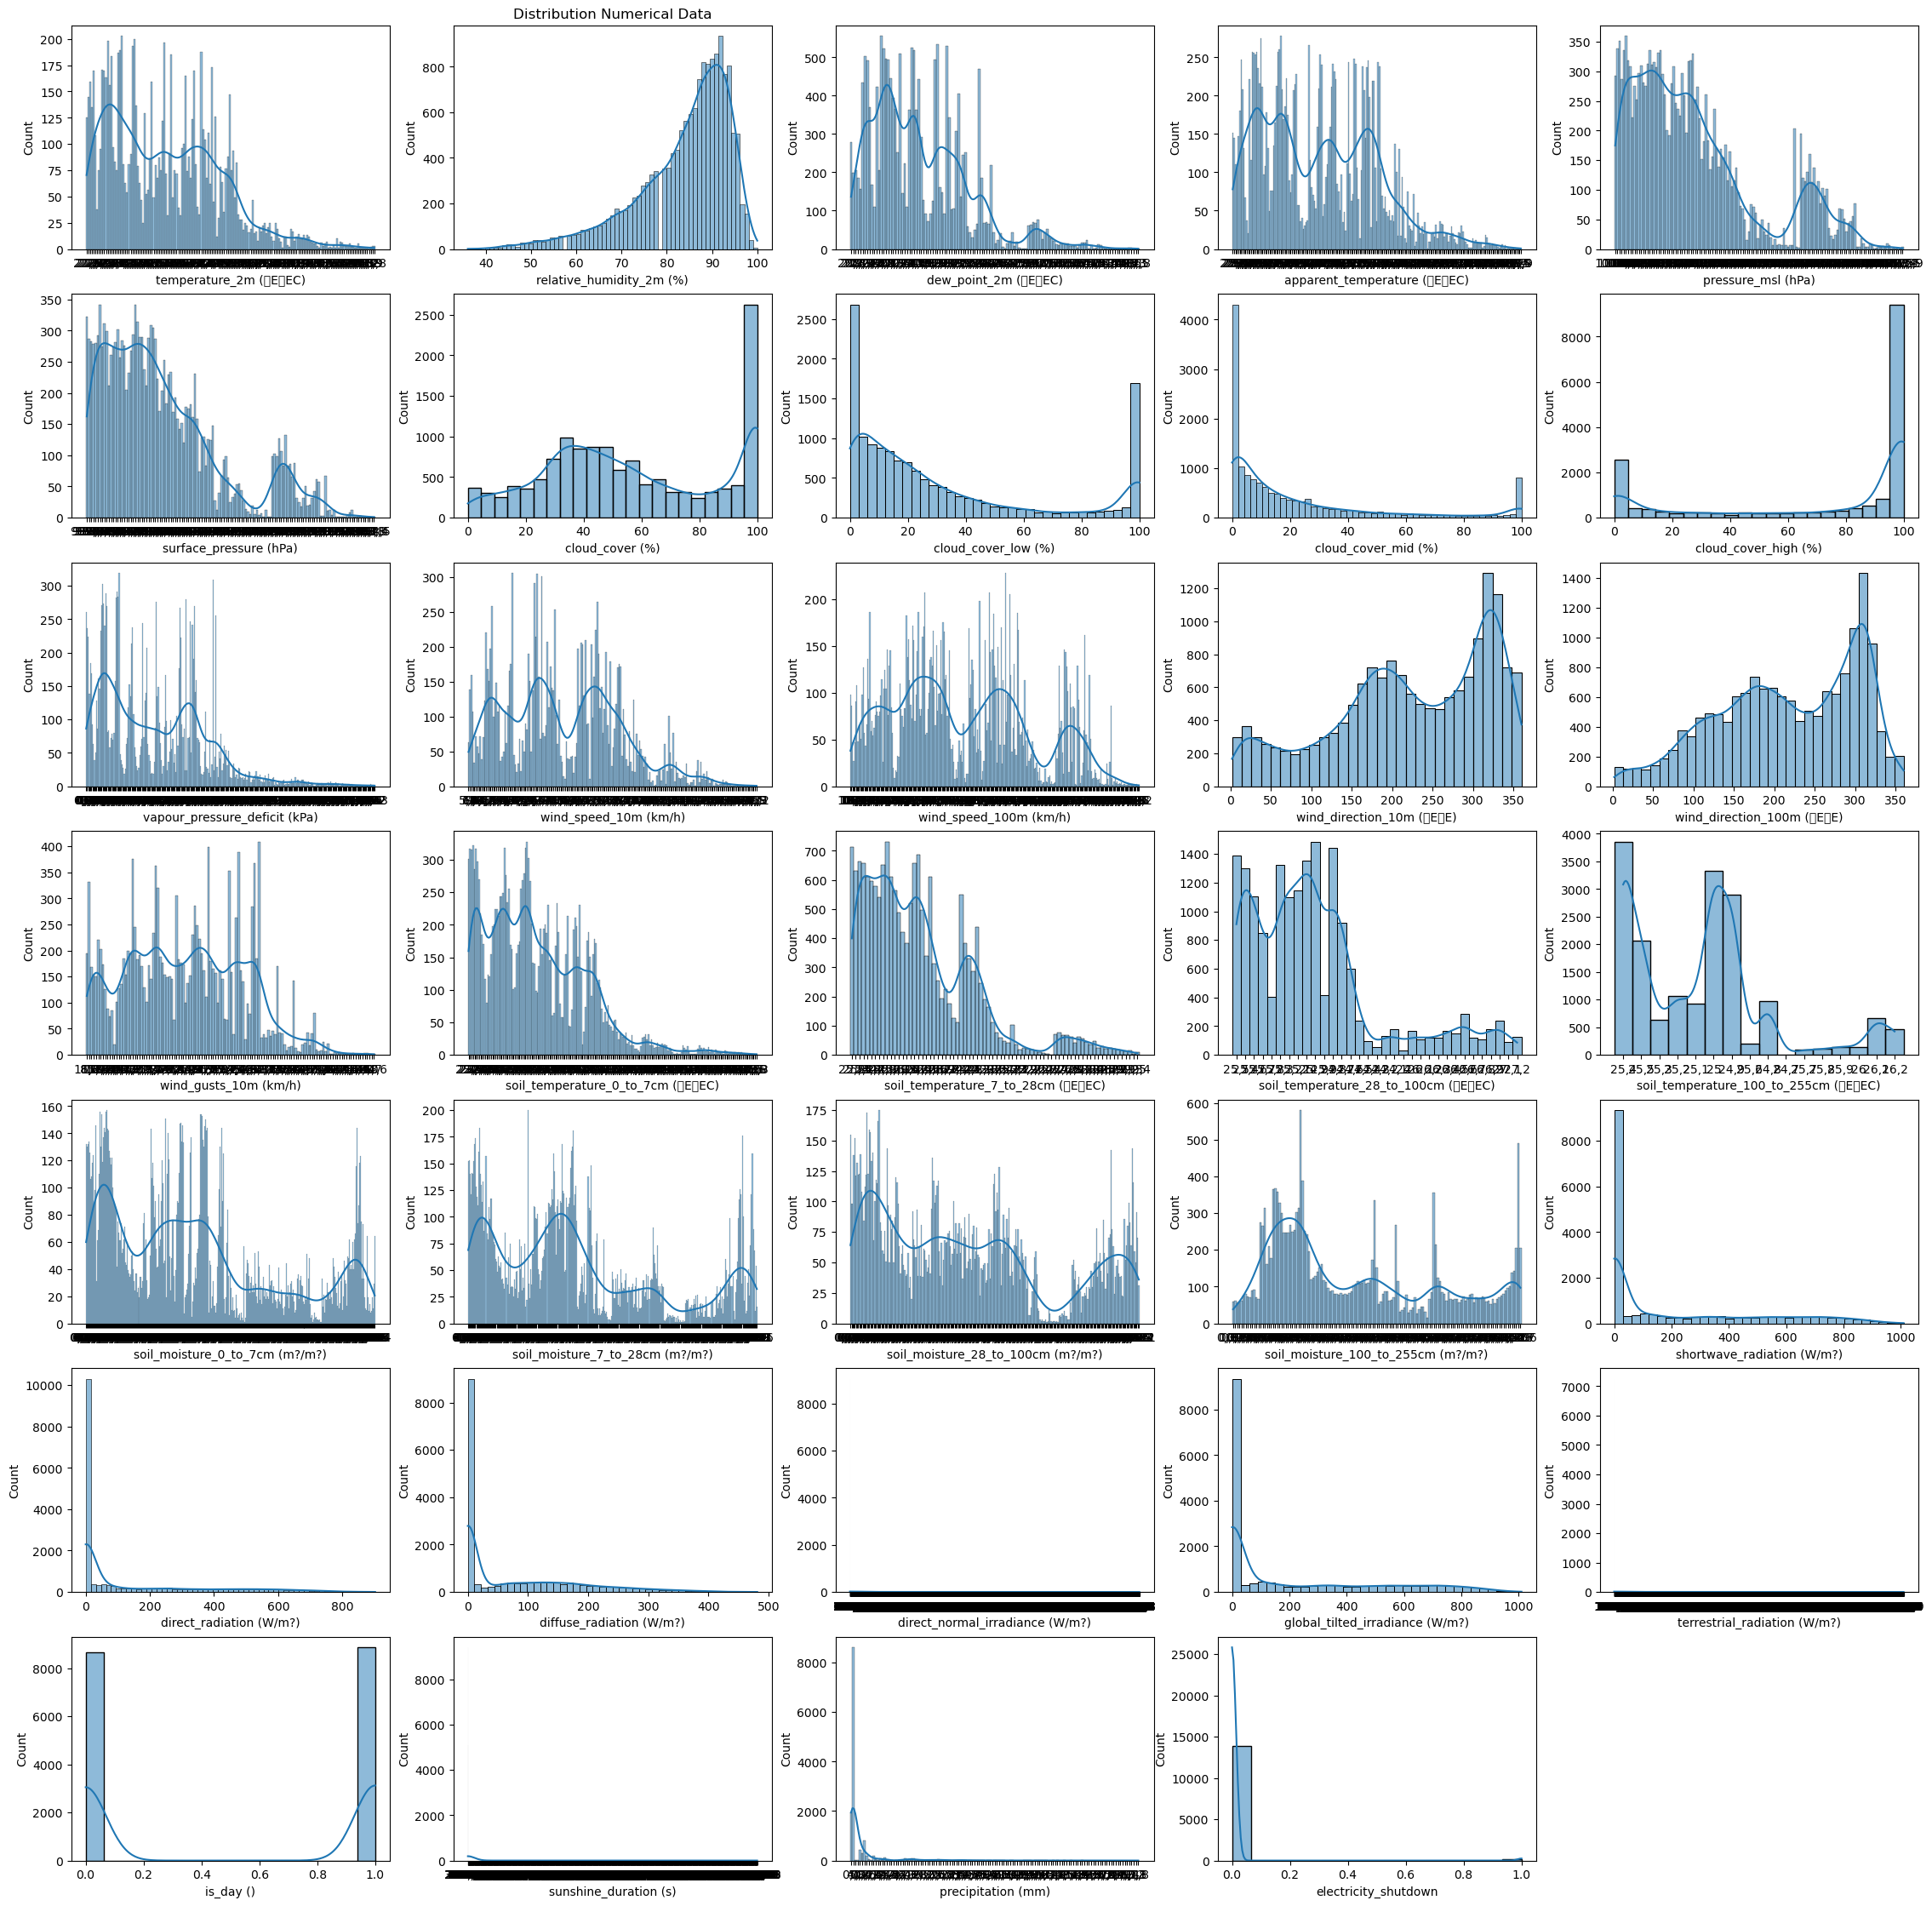

In [52]:
plt.figure(figsize=(28, 28))

n = 0
for cols in df_train.columns:
    n += 1
    plt.subplot(7, 5, n)  # Menggunakan grid 5x5
    sns.histplot(df_train[cols], kde=True)
    plt.title('Distribution Numerical Data' if n == 2 else '')

plt.show()

In [53]:
negative_skewed_high = ["relative_humidity_2m (%)", "dew_point_2m (?E?EC)", "apparent_temperature (?E?EC)","soil_temperature_0_to_7cm (?E?EC)", "soil_temperature_7_to_28cm (?E?EC)", "soil_temperature_28_to_100cm (?E?EC)", "soil_temperature_100_to_255cm (?E?EC)"]
negative_skewed_low = ["soil_moisture_0_to_7cm (m?/m?)", "soil_moisture_7_to_28cm (m?/m?)", "soil_moisture_100_to_255cm (m?/m?)"]
positive_skewed = ["cloud_cover_low (%)", "vapour_pressure_deficit (kPa)", "wind_speed_10m (km/h)", "wind_speed_100m (km/h)", "wind_gusts_10m (km/h)"]

In [54]:
# pt = PowerTransformer(method='yeo-johnson')
# df_train[positive_skewed] = np.sqrt(df_train[positive_skewed])
# df_train[negative_skewed_high] = pt.fit_transform(df_train[negative_skewed_high])
# df_train[negative_skewed_low] = np.power(df_train[negative_skewed_low] + 1, 2)

/opt/anaconda3/envs/Lomba/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


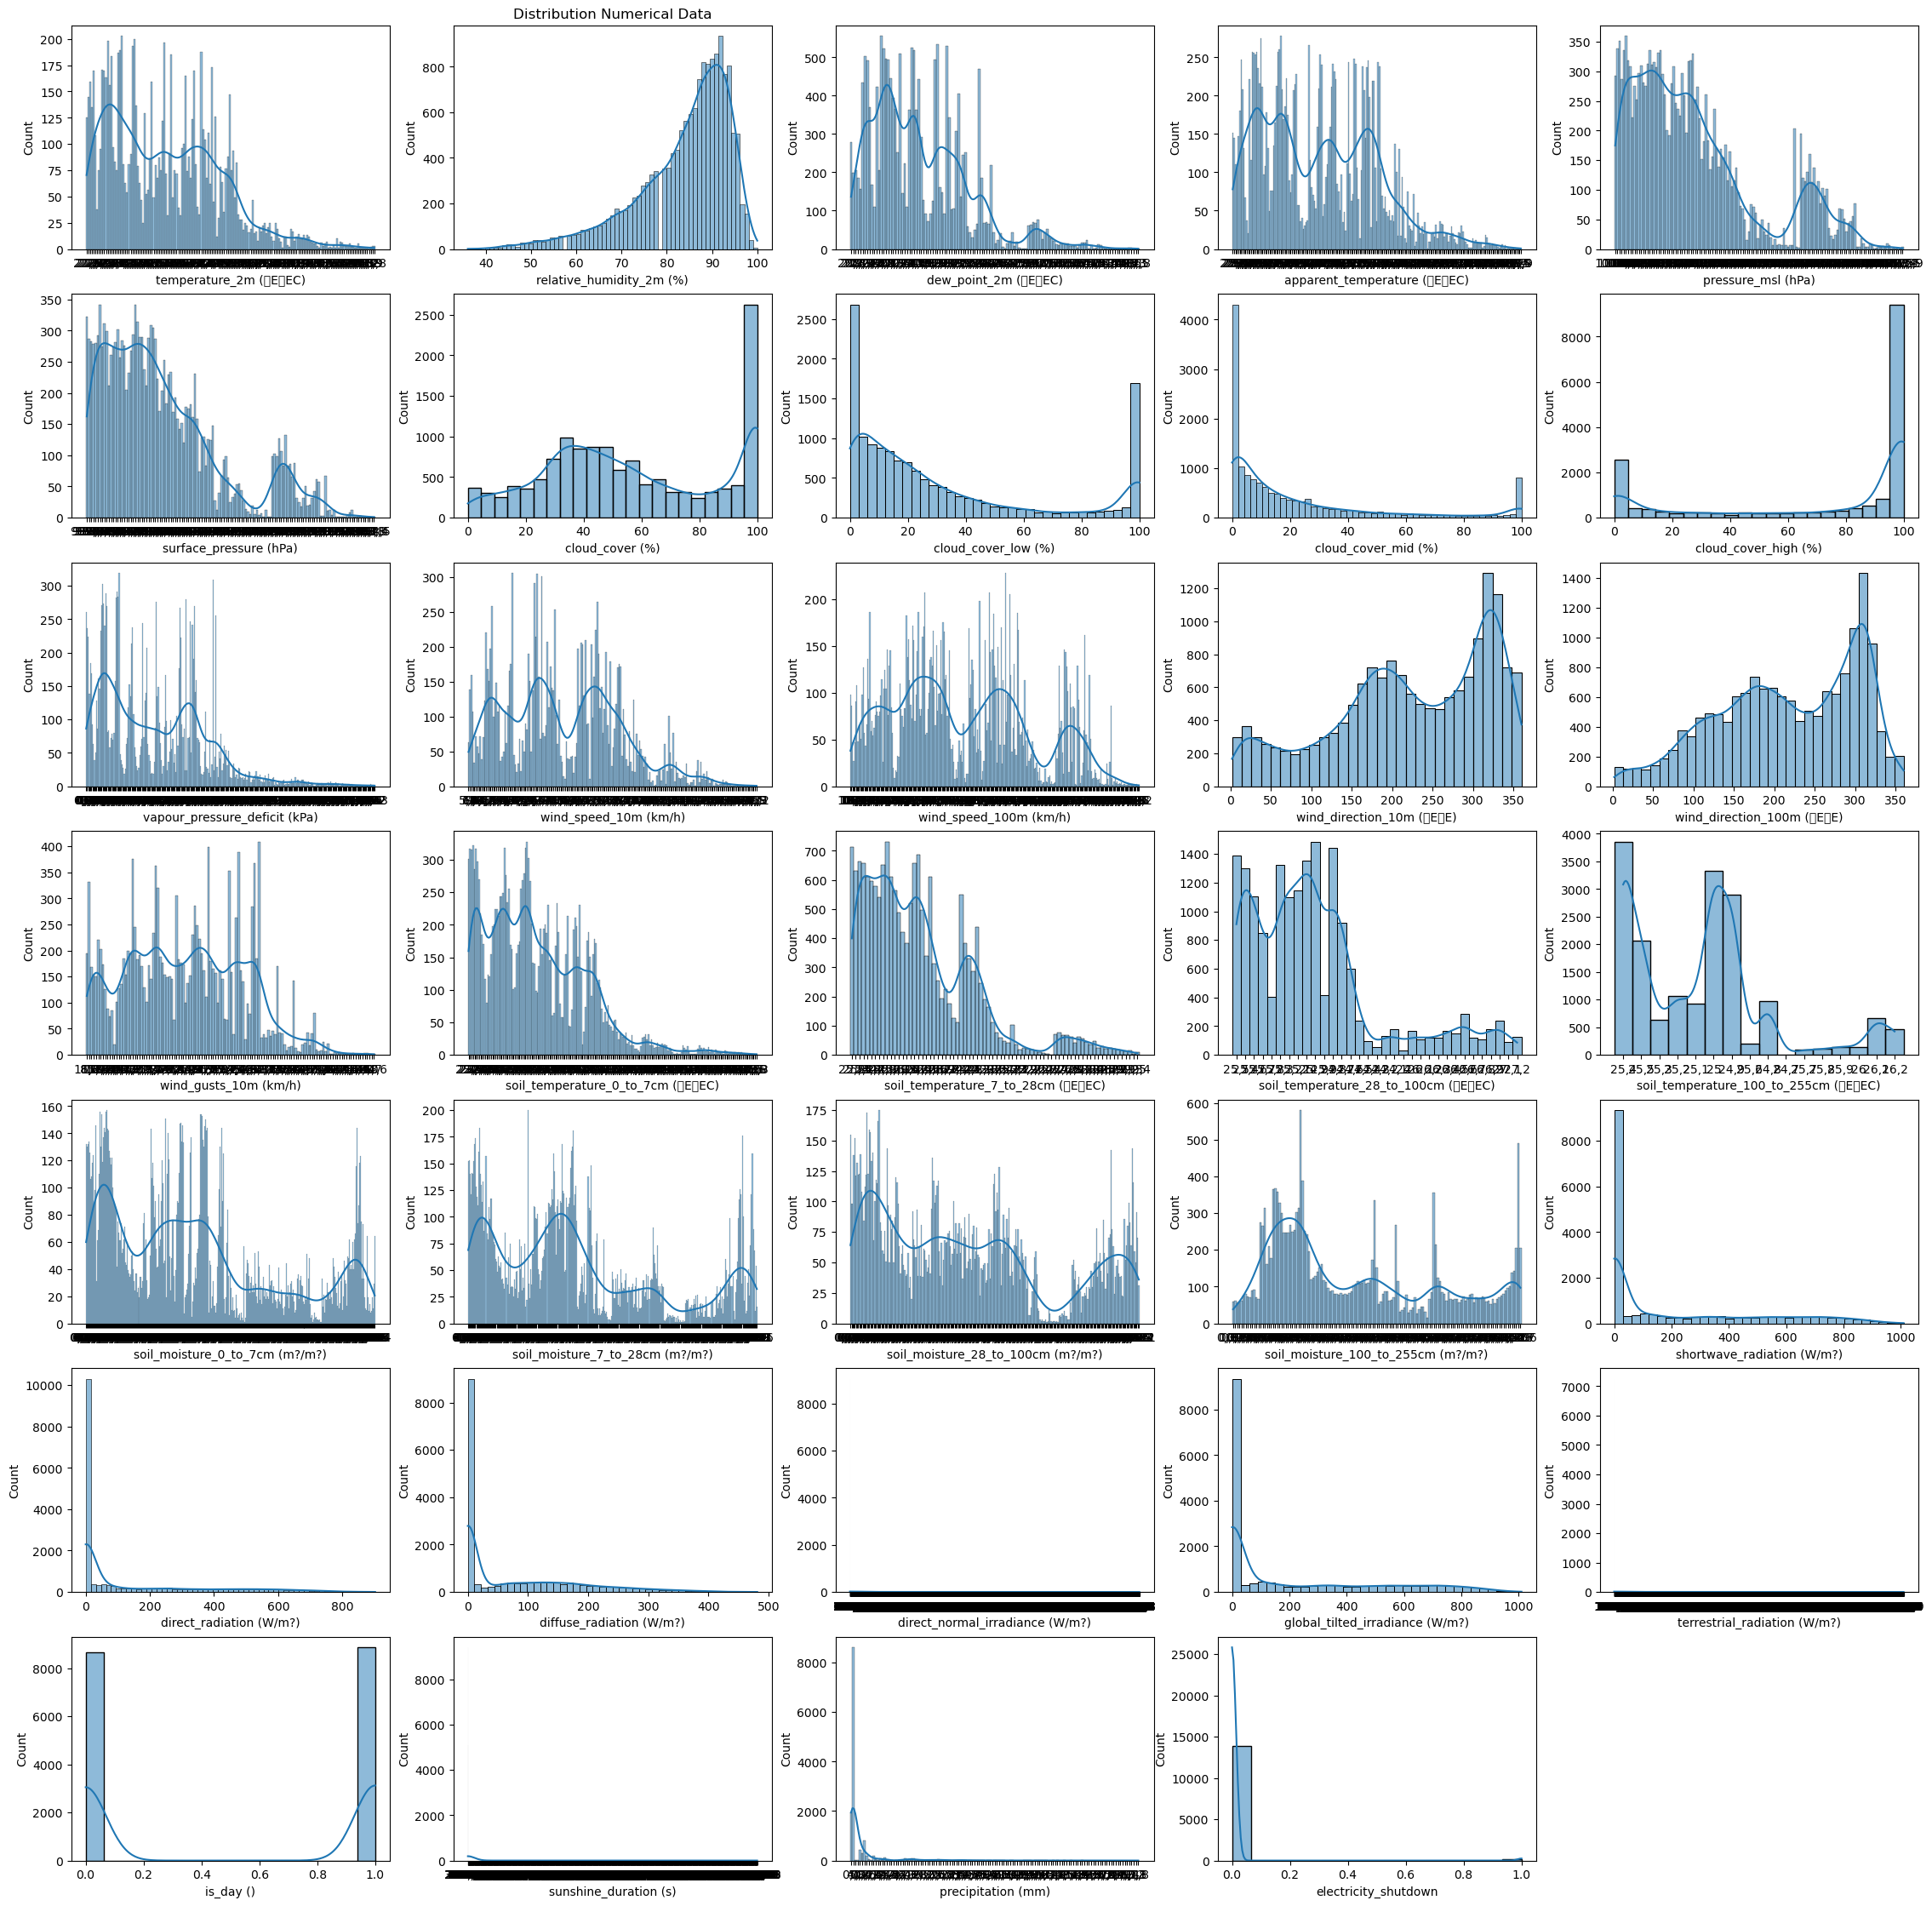

In [55]:
plt.figure(figsize=(28, 28))

n = 0
for cols in df_train.columns:
    n += 1
    plt.subplot(7, 5, n)  # Menggunakan grid 5x5
    sns.histplot(df_train[cols], kde=True)
    plt.title('Distribution Numerical Data' if n == 2 else '')

plt.show()

In [56]:
temp_train = df_train["electricity_shutdown"]
df_train.drop(columns="electricity_shutdown", inplace = True)

/var/folders/9d/fp3wp_nx6xqbblmg0zr1yk700000gn/T/ipykernel_12572/3904899769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns="electricity_shutdown", inplace = True)


In [57]:
df_train['precipitation (mm)']

time
2022-01-01T00:00    0,1
2022-01-01T01:00      0
2022-01-01T02:00      0
2022-01-01T03:00      0
2022-01-01T04:00      0
                   ... 
2023-12-31T19:00    NaN
2023-12-31T20:00    2,2
2023-12-31T21:00    NaN
2023-12-31T22:00    1,8
2023-12-31T23:00      0
Name: precipitation (mm), Length: 17520, dtype: object

In [58]:
df_train['precipitation (mm)'] = df_train['precipitation (mm)'].astype(str)
df_train['precipitation (mm)'] = df_train['precipitation (mm)'].apply(lambda x: x.replace(',','.'))
df_train['precipitation (mm)'] = pd.to_numeric(df_train['precipitation (mm)'], errors="coerce")
cobak = df_train.dropna()

/var/folders/9d/fp3wp_nx6xqbblmg0zr1yk700000gn/T/ipykernel_12572/3527745792.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['precipitation (mm)'] = df_train['precipitation (mm)'].astype(str)
/var/folders/9d/fp3wp_nx6xqbblmg0zr1yk700000gn/T/ipykernel_12572/3527745792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['precipitation (mm)'] = df_train['precipitation (mm)'].apply(lambda x: x.replace(',','.'))
/var/folders/9d/fp3wp_nx6xqbblmg0zr1yk700000gn/T/ipykernel_12572/3527745792.py:3

In [59]:
cobak.dtypes

temperature_2m (EEC)                    object
relative_humidity_2m (%)                 float64
dew_point_2m (EEC)                      object
apparent_temperature (EEC)              object
pressure_msl (hPa)                        object
surface_pressure (hPa)                    object
cloud_cover (%)                          float64
cloud_cover_low (%)                      float64
cloud_cover_mid (%)                      float64
cloud_cover_high (%)                       int64
vapour_pressure_deficit (kPa)             object
wind_speed_10m (km/h)                     object
wind_speed_100m (km/h)                    object
wind_direction_10m (EE)                float64
wind_direction_100m (EE)               float64
wind_gusts_10m (km/h)                     object
soil_temperature_0_to_7cm (EEC)         object
soil_temperature_7_to_28cm (EEC)        object
soil_temperature_28_to_100cm (EEC)      object
soil_temperature_100_to_255cm (EEC)     object
soil_moisture_0_to_7

/opt/anaconda3/envs/Lomba/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.draw()
/opt/anaconda3/envs/Lomba/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


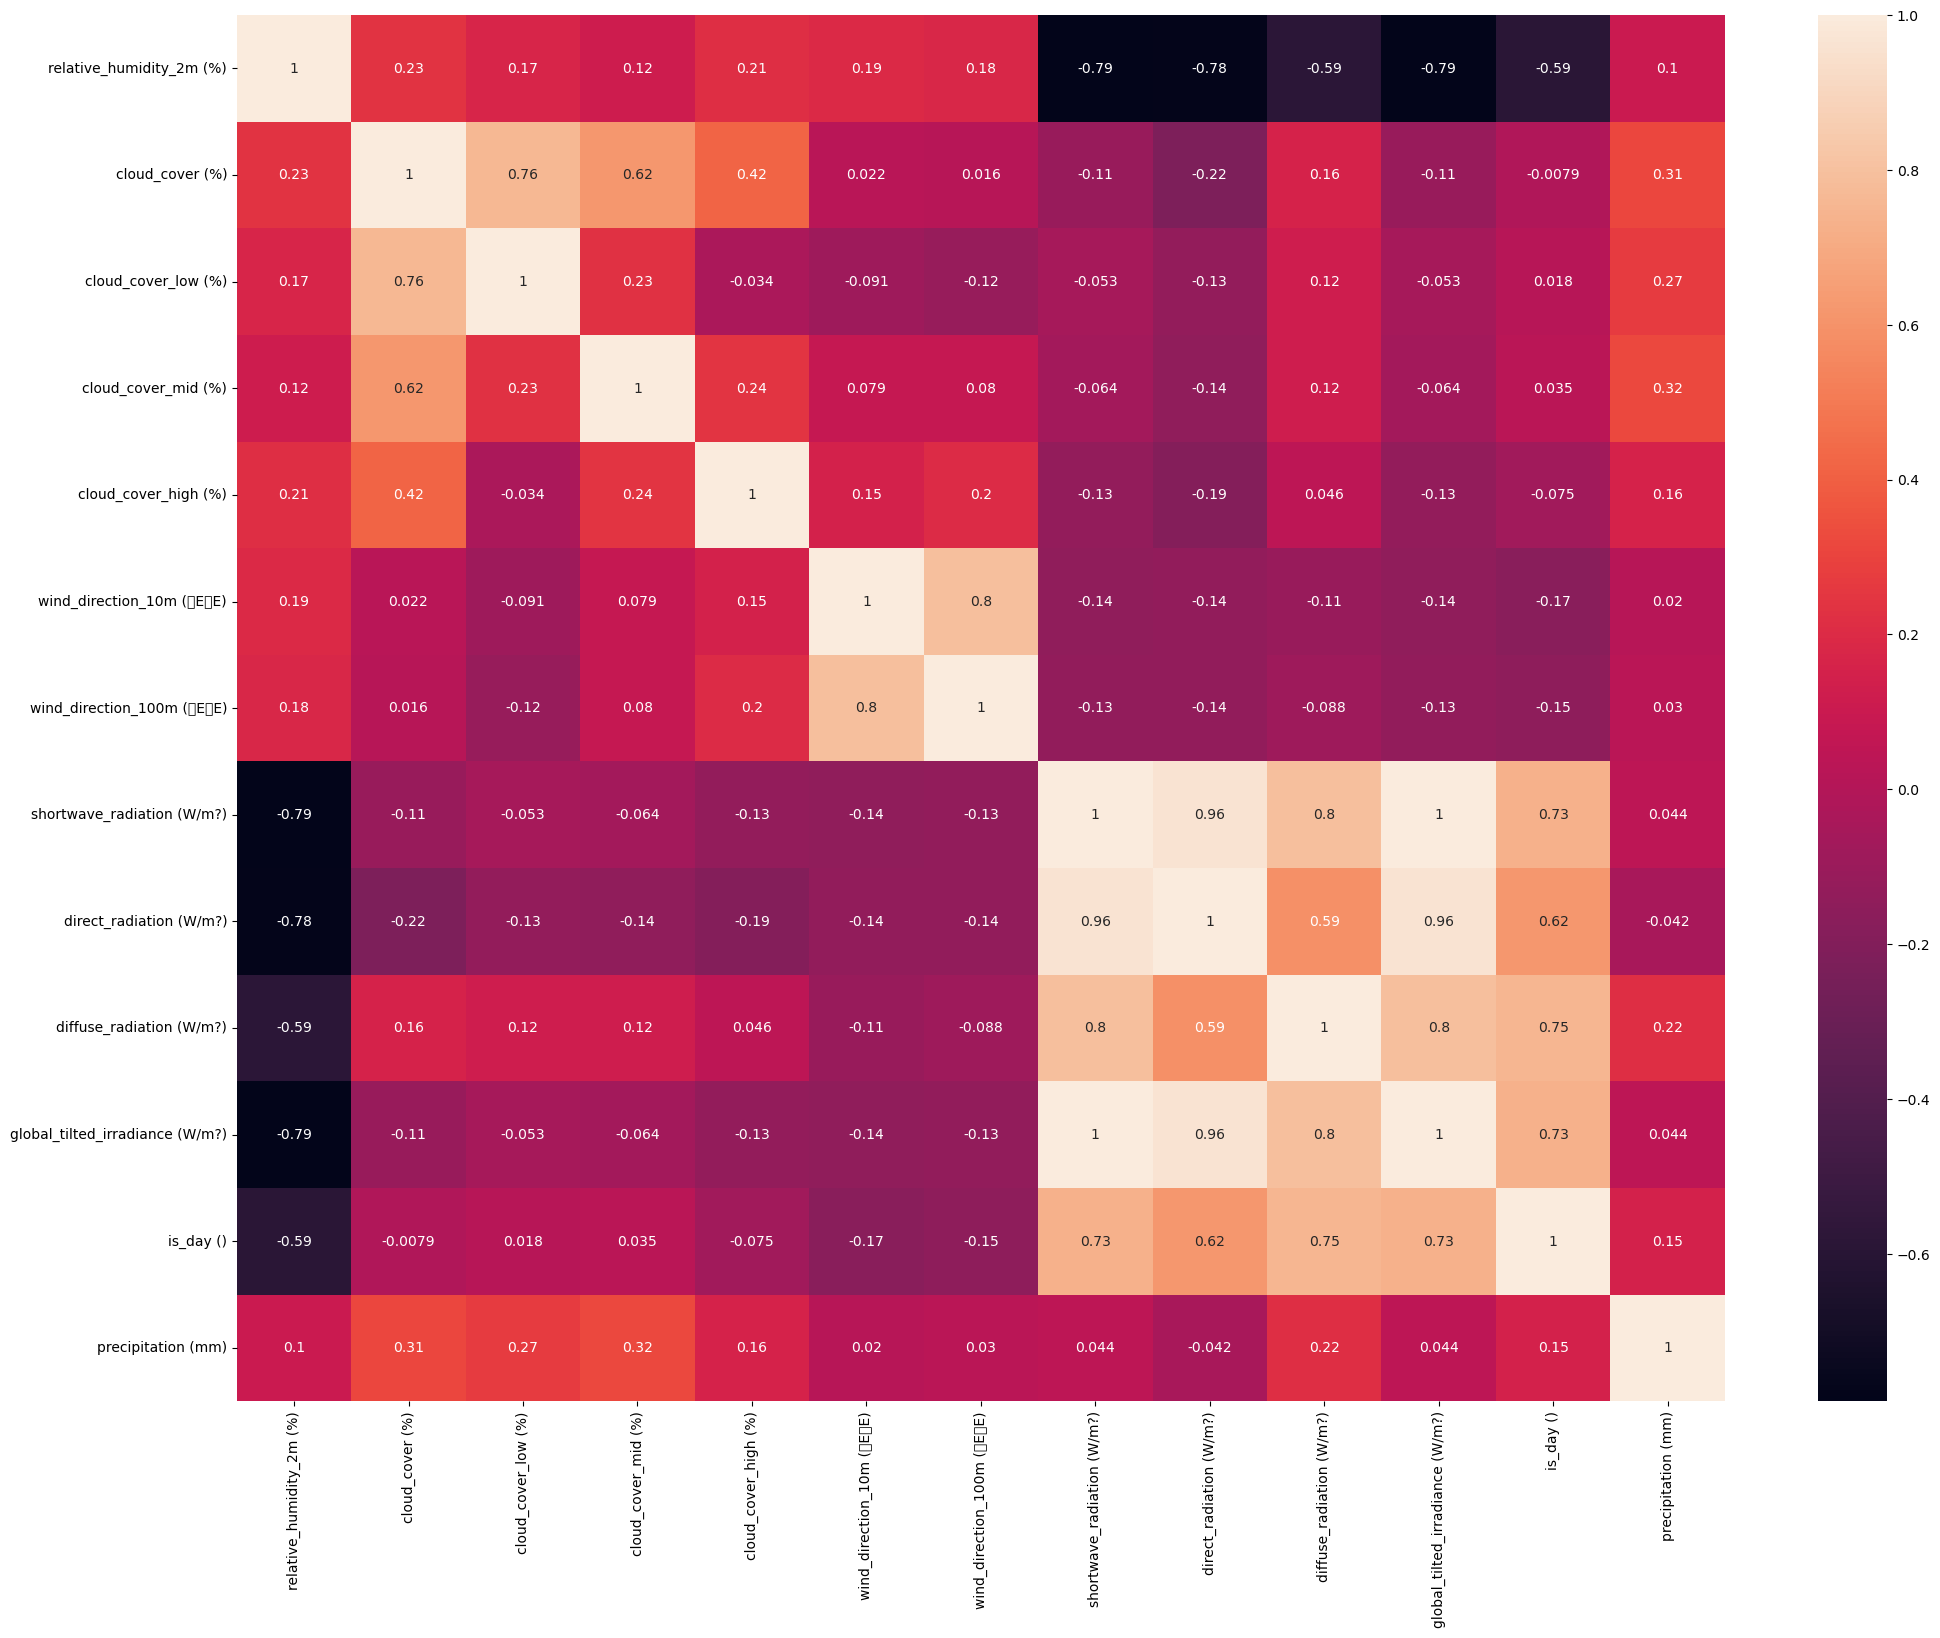

In [60]:
plt.figure(figsize=(24, 18))
sns.heatmap(cobak.corr(numeric_only=True), annot=True)
plt.show()

In [61]:
temp = cobak["precipitation (mm)"]
cobak.drop(columns="precipitation (mm)", inplace = True)

/var/folders/9d/fp3wp_nx6xqbblmg0zr1yk700000gn/T/ipykernel_12572/4171438458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cobak.drop(columns="precipitation (mm)", inplace = True)


In [66]:
df = len(cobak)-2
alpha = 0.5

t_critical = stats.t.ppf(1 - alpha/2, df)
print(t_critical)

0.6747067309255409


In [67]:
kolom_digunakan = []
kolom_tidak_digunakan = []

for kolom in cobak.columns:
    r = cobak[kolom].corr(temp)
    t0 = (r*np.sqrt(len(cobak)-2)) / (1-r**2)
    if abs(t0) < t_critical:
        kolom_tidak_digunakan.append(kolom)
        print(f"H0 gagal ditolak pada variabel {kolom} dengan korelasi {r}, yang artinya tidak berhubungan")
    else:
        kolom_digunakan.append(kolom)
        print(f"H0 ditolak pada variabel {kolom} dengan korelasi {r}, yang artinya terdapat hubungan")

print("\n")
print("Kolom yang digunakan adalah:")
print(kolom_digunakan)

print("\n")
print("Kolom yang tidak digunakan adalah:")
print(kolom_tidak_digunakan)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [ ]:
cobak = df_train[kolom_digunakan].dropna()

In [ ]:
X_train = cobak.iloc[:, :-1].values
y_train = cobak.iloc[:, -1].values

### Splitting Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Bangun Model

In [ ]:
def rmse(y_true, y_pred):
    return K.sqrt(MeanSquaredError()(y_true, y_pred))

ann = Sequential()
ann.add(Dense(units=200, activation="relu"))
ann.add(Dense(units=200, activation="relu"))
ann.add(Dense(units=1))

# Mengompilasi model dengan RMSE sebagai fungsi loss
ann.compile(optimizer="adam", loss=rmse)

In [ ]:
# ann.fit(X_train, y_train, batch_size = 32, epochs = 80)
# y_pred = ann.predict(X_test)

# print(f"Nilai RMSE dari ANN adalah {rmse(y_test, y_pred)}")

In [ ]:
rf = RandomForestRegressor(random_state=42, n_estimators=400)

In [ ]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Nilai RMSE dari RandomForest adalah {rmse(y_test, y_pred)}")

In [ ]:
np.vstack((y_test,y_pred))

In [ ]:
knn = KNeighborsRegressor(n_neighbors=9)

In [ ]:
# knn.fit(X_train, y_train)
# y_pred = knn.predict(X_test)

# print(f"Nilai RMSE dari KNN adalah {rmse(y_test, y_pred)}")

In [ ]:
svr = SVR(
    C=1.0,        # Regularization parameter
    kernel='rbf', # Kernel function, bisa diganti dengan 'linear', 'poly', atau 'sigmoid'
    gamma='scale' # Kernel coefficient, bisa diganti dengan 'auto' atau nilai numerik
)

In [ ]:
# svr.fit(X_train, y_train)
# y_pred = svr.predict(X_test)

# print(f"Nilai RMSE dari svr adalah {rmse(y_test, y_pred)}")

### Mengisi Nilai yang Hilang

In [ ]:
cobak = df_train[kolom_digunakan].dropna()

In [ ]:
X_train = cobak.iloc[:, :-1].values
y_train = cobak.iloc[:, -1].values

In [ ]:
baris_kosong = df_train[df_train["precipitation (mm)"].isnull()]
baris_kosong = baris_kosong[kolom_digunakan]

In [ ]:
X_test = baris_kosong.iloc[:, :-1].values
y_test = baris_kosong.iloc[:, -1].values

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
pred = rf.predict(X_test)

In [ ]:
df_train.head(30)

In [ ]:
pred_index = 0
for i in range(len(df_train)):
    if pd.isnull(df_train.iloc[i, 32]):  
        df_train.iloc[i, 32] = pred[pred_index]  
        pred_index += 1  

In [ ]:
df_train.isna().sum()

In [ ]:
df_train.head()

In [ ]:
df_test.isna().sum()

In [ ]:
temp_A = df_train["precipitation (mm)"]
df_train.drop(columns="precipitation (mm)", inplace = True)

In [ ]:
df_train["electricity_shutdown"] = temp_train

In [ ]:
cobak2 = df_train.dropna()

baris_kosong2 = df_train[df_train["electricity_shutdown"].isnull()]

In [ ]:
cobak2["electricity_shutdown"]

### Splitting

In [ ]:
X_train = cobak2.iloc[:, :-1].values
y_train = cobak2.iloc[:, -1].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### FE

In [ ]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pd.DataFrame(y_train).value_counts()

In [ ]:
len(X_train)

In [ ]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)

In [ ]:
chi_selector = SelectKBest(chi2, k=25)  # Memilih 2 fitur terbaik
X_kbest = chi_selector.fit_transform(X_train, y_train)

In [ ]:
X_train.shape

### Pemilihan Model

In [ ]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Membulatkan prediksi ke 0 atau 1
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    precision = tp / (K.sum(K.cast(y_pred, 'float'), axis=0) + K.epsilon())
    recall = tp / (K.sum(K.cast(y_true, 'float'), axis=0) + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=200, activation="relu")) #rectifier
ann.add(tf.keras.layers.Dense(units=200, activation="relu")) #rectifier
ann.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) #sigmoid
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_score])

In [ ]:
ann.fit(X_train, y_train)
y_pred = ann.predict(X_test)

print(f"Nilai f1_score dari ANN adalah {f1_score(y_test, y_pred)}")
print(f"Nilai accuracy dari ANN adalah {accuracy_score(y_test, y_pred)}")

In [ ]:
pd.DataFrame(y_pred).value_counts()

In [ ]:
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=150, max_depth=3, random_state=42)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

print(f"Nilai f1_score dari GBC adalah {f1_score(y_test, y_pred)}")
print(f"Nilai accuracy dari GBC adalah {accuracy_score(y_test, y_pred)}")

In [ ]:
pd.DataFrame(y_pred).value_counts()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f"Nilai f1_score dari knn adalah {f1_score(y_test, y_pred)}")
print(f"Nilai accuracy dari knn adalah {accuracy_score(y_test, y_pred)}")

In [ ]:
pd.DataFrame(y_pred).value_counts()

In [ ]:
etc = ExtraTreesClassifier(n_estimators=200, max_depth=20, random_state=42)
etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)

print(f"Nilai f1_score dari etc adalah {f1_score(y_test, y_pred)}")
print(f"Nilai accuracy dari etc adalah {accuracy_score(y_test, y_pred)}")

In [ ]:
pd.DataFrame(y_pred).value_counts()

In [ ]:
xgb = XGBClassifier(learning_rate=0.05, n_estimators=200, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(f"Nilai f1_score dari xgb adalah {f1_score(y_test, y_pred)}")
print(f"Nilai accuracy dari xgb adalah {accuracy_score(y_test, y_pred)}")

In [ ]:
pd.DataFrame(y_pred).value_counts()

### Mengisi nilai kosong

In [ ]:
cobak2 = df_train.dropna()

baris_kosong2 = df_train[df_train["electricity_shutdown"].isnull()]

In [ ]:
X_train = cobak2.iloc[:, :-1].values
y_train = cobak2.iloc[:, -1].values

X_test = baris_kosong2.iloc[:, :-1].values
y_test = baris_kosong2.iloc[:, -1].values

In [ ]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)

In [ ]:
etc = ExtraTreesClassifier(n_estimators=200, max_depth=20, random_state=42)
etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)

In [ ]:
pd.DataFrame(y_pred).value_counts()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [ ]:
pd.DataFrame(y_pred).value_counts()

In [ ]:
pred_index = 0
for i in range(len(df_train)):
    if pd.isnull(df_train.iloc[i, 32]):  
        df_train.iloc[i, 32] = y_pred[pred_index]  
        pred_index += 1  

In [ ]:
df_train.isna().sum()

In [ ]:
df_test.head()

In [ ]:
# pt = PowerTransformer(method='yeo-johnson')
# df_test[positive_skewed] = np.sqrt(df_test[positive_skewed])
# df_test[negative_skewed_high] = pt.fit_transform(df_test[negative_skewed_high])
# df_test[negative_skewed_low] = np.power(df_test[negative_skewed_low] + 1, 2)

### Prediksi Klasifikasi

In [ ]:
X_train1 = df_train.iloc[:, :-1].values
y_train1 = df_train.iloc[:, -1].values

X_test1 = df_test.iloc[:, :].values

In [ ]:
smote = SMOTE(random_state=42)
X_train1, y_train1 = smote.fit_resample(X_train1, y_train1)

In [ ]:
sc = MinMaxScaler()
X_train1 = sc.fit_transform(X_train1)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')
knn.fit(X_train1, y_train1)
class_pred = knn.predict(X_test1)

In [ ]:
pd.DataFrame(class_pred).value_counts()

In [ ]:
etc = ExtraTreesClassifier(n_estimators=200, max_depth=20, random_state=42)
etc.fit(X_train1, y_train1)
class_pred = etc.predict(X_test1)

In [ ]:
pd.DataFrame(class_pred).value_counts()

### Prediksi Kontinu

In [ ]:
df_train = df_train[kolom_digunakan]
df_train["precipitation (mm)"] = temp_A
df_test = df_test[kolom_digunakan]

In [ ]:
X_train2 = df_train.iloc[:, :-1].values
y_train2 = df_train.iloc[:, -1].values

X_test2 = df_test.iloc[:, :].values

In [ ]:
rf = RandomForestRegressor(random_state=42, n_estimators=400)

In [ ]:
rf.fit(X_train2, y_train2)

In [ ]:
kontinu_pred = rf.predict(X_test2)

In [ ]:
df_sub["precipitation (mm)"] = kontinu_pred
df_sub["electricity_shutdown"] = class_pred
df_sub

In [ ]:
df_sub["electricity_shutdown"] = df_sub["electricity_shutdown"].astype(int)
df_sub

In [ ]:
import os

# Ubah ke direktori yang diinginkan
os.chdir("D:\SSDS")

# Cek direktori kerja saat ini
print(os.getcwd())

In [ ]:
df_sub.to_csv("sub1.csv", index=False)